In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import dataframe_image as dfi
from datetime import datetime
from sklearn.linear_model import LinearRegression
%matplotlib inline
sns.set_palette(sns.color_palette('rocket_r'))
sns.set_style("whitegrid")

In [2]:
listings = pd.read_csv('listings.csv')
listings_sum = pd.read_csv('listings_sum.csv')
reviews_sum = pd.read_csv('reviews_sum.csv')

# How's the difference across counties

First let's take a look at the overview

In [3]:
print('# listings in NYC: ', listings.shape[0])

# listings in NYC:  36905


In [4]:
df_dist_county = listings['neighbourhood_group_cleansed'].value_counts(normalize=True)
print(df_dist_county)

Manhattan        0.441512
Brooklyn         0.392630
Queens           0.130822
Bronx            0.027097
Staten Island    0.007939
Name: neighbourhood_group_cleansed, dtype: float64


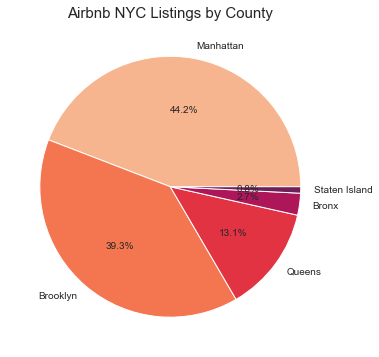

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches((6,6))
ax.pie(df_dist_county, labels = df_dist_county.index, 
        autopct='%1.1f%%',
        shadow=False)
ax.set_title('Airbnb NYC Listings by County', fontsize = 15)
fig.savefig('listings_by_county.png')
plt.show()

Next let's look at the price. But first we need to convert it to numbers.

In [6]:
listings.price.value_counts()

$150.00      1298
$100.00      1236
$50.00       1088
$60.00        923
$80.00        890
             ... 
$507.00         1
$1,025.00       1
$740.00         1
$496.00         1
$839.00         1
Name: price, Length: 777, dtype: int64

In [7]:
listings['price_f'] = listings.price.str.replace('\$|,', '').astype('float')

In [8]:
pd.options.display.float_format = '{:.2f}'.format
df_price_by_loc_type = listings.groupby(['neighbourhood_group_cleansed', 'room_type'])\
        .agg({'price_f': ['mean'], 'id':['count']})\
        .sort_values(('price_f','mean'), ascending=False).reset_index()
df_price_by_loc_type.columns = ['County', 'Room Type', 'Avg. Price', '#']
df_price_by_loc_type

,County,Room Type,Avg. Price,#
0,Manhattan,Hotel room,305.25,253
1,Manhattan,Entire home/apt,225.39,9832
2,Queens,Hotel room,178.89,9
3,Brooklyn,Entire home/apt,176.27,7170
4,Queens,Entire home/apt,163.39,1698
5,Brooklyn,Hotel room,161.42,19
6,Staten Island,Entire home/apt,150.33,150
7,Manhattan,Shared room,149.27,277
8,Bronx,Entire home/apt,146.51,393
9,Manhattan,Private room,124.41,5932


In [9]:
df_price_by_loc_type.dfi.export('df_price_by_loc_type.png')

In [10]:
df_price_by_loc_type.sort_values('Avg. Price', ascending = True, inplace = True)

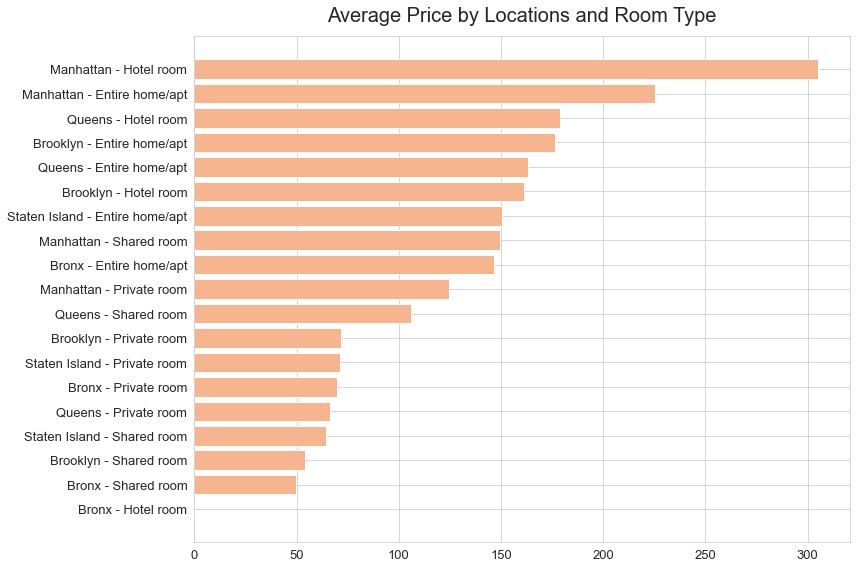

In [11]:
plt.figure(figsize=(12,8))
plt.barh(df_price_by_loc_type.County + ' - ' + df_price_by_loc_type['Room Type'], df_price_by_loc_type['Avg. Price'])
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Average Price by Locations and Room Type', fontsize = 20, pad=15)
plt.tight_layout()
plt.savefig('price_by_type.png')
plt.show()

Then what about the rating scores? Does the most expensive area provide the best experience? <br/> Surprisingly, quite the contrary.

In [12]:
df_review = listings.groupby(['neighbourhood_group_cleansed'])[['review_scores_rating']].mean().sort_values(by = 'review_scores_rating', ascending = False).reset_index()
df_review.columns = ['County', 'Avg. Rating']
df_review.dfi.export('avg_rating_loc.png')

# What time do people usually visit the big apple

From the Airbnb data we cannot really know when exactly does people visit the city. But assuming that people usually comment or review their experience soon after their trip, we can use time of the reviews as a proxy to answer the question.

First let's take a look at the history by date:

In [13]:
df_daily = reviews_sum.groupby('date').count()

In [14]:
df_daily.index = pd.to_datetime(df_daily.index)

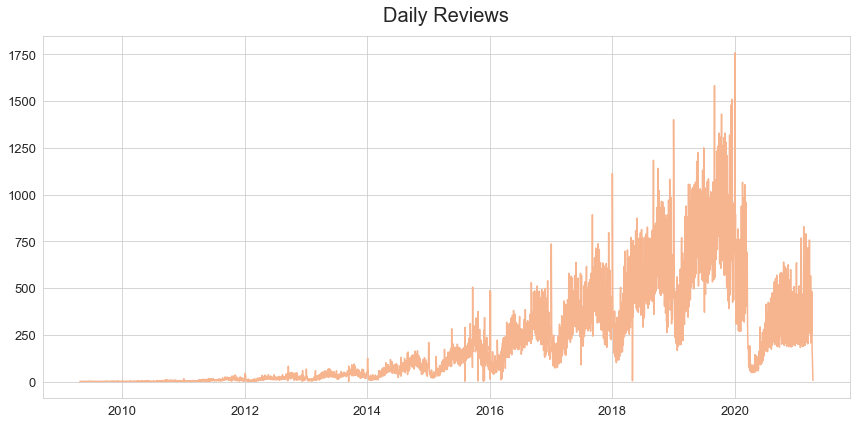

In [15]:
plt.figure(figsize = (12,6))
plt.plot(df_daily)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Daily Reviews', fontsize = 20, pad=15)
plt.tight_layout()
plt.savefig('reviews_daily.png')
plt.show()

Although this is not the best and clearest way to show it, we can still see the increasing trend and seasonality.

Next, let's separate the general trend and seasonality to take a closer look. And we are only doing it using the most recent data of 2014 - 2019. We are excluding 2020 for obvious reasons.

In [16]:
reviews_daily = reviews_sum[(reviews_sum.date >= '2014-01-01') & (reviews_sum.date <= '2019-12-31')].groupby('date').count()

In [17]:
date_list = pd.date_range(start="2014-01-01",end="2019-12-31")

To remove the fluctuation, let's take a rolling window of 365 days and look at the average number:

In [18]:
reviews_daily.index = pd.to_datetime(reviews_daily.index)
reviews_daily = reviews_daily.reindex(date_list, method='pad')
# reviews_daily

In [19]:
# lr = LinearRegression()
model = np.polyfit(range(reviews_daily.shape[0]), reviews_daily['listing_id'],2)
fit = np.poly1d(model)
fit(range(reviews_daily.shape[0]))

array([ 55.58293803,  55.6190001 ,  55.65532895, ..., 772.78683428,
       773.40661843, 774.02666936])

In [20]:
reviews_daily['poly_fit'] = fit(range(reviews_daily.shape[0]))

In [21]:
reviews_daily_y= reviews_daily.rolling(365).mean().dropna()

In [22]:
reviews_daily_y.head()

,listing_id,poly_fit
2014-12-31,64.08,68.02
2015-01-01,64.35,68.11
2015-01-02,64.64,68.19
2015-01-03,64.83,68.28
2015-01-04,65.04,68.36


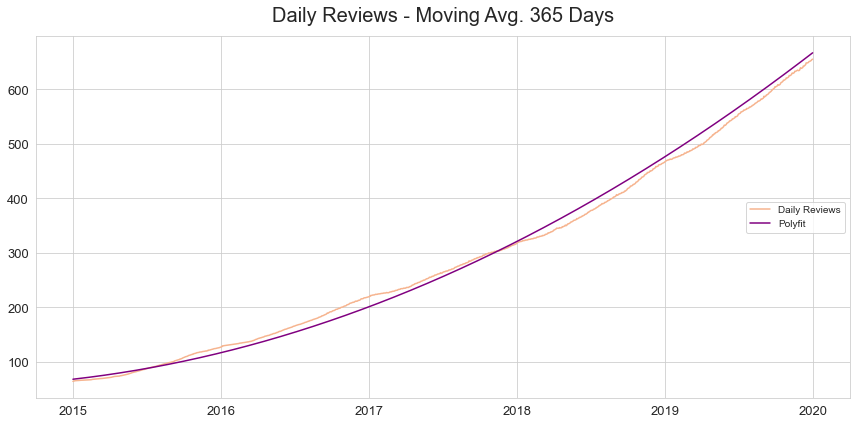

In [23]:
# reviews_daily.rolling(365).mean().dropna().plot()
plt.figure(figsize = (12,6))
plt.plot(reviews_daily_y['listing_id'], label = 'Daily Reviews')
plt.plot(reviews_daily_y['poly_fit'], color = 'purple', label = 'Polyfit')
# plt.plot(list(lr.predict(np.array(range(reviews_daily.shape[0])).reshape(730,1)).reshape(730,)))
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(loc = 'right')
plt.title('Daily Reviews - Moving Avg. 365 Days', fontsize = 20, pad=15)
plt.tight_layout()
plt.savefig('reviews_daily_y.png')
plt.show()

To look at the seasonality, we first roll up the daily number to monthly sum, then divide them by the total number of that year to see what's the percentage. 

In [24]:
# reviews_daily.index = pd.to_datetime(reviews_daily.index)
reviews_monthly = reviews_daily.resample('M').sum()[['listing_id']]
reviews_monthly['Year'] = reviews_monthly.index.year
reviews_monthly['Annual sum'] = reviews_monthly.groupby(['Year'])['listing_id']\
                        .transform('sum')
reviews_monthly['pct_annual'] = reviews_monthly['listing_id']/reviews_monthly['Annual sum']

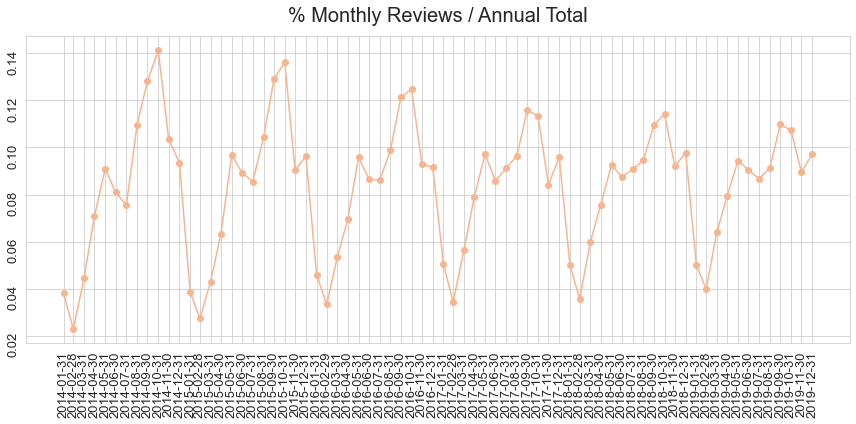

In [25]:
plt.figure(figsize=(12,6))
plt.plot(reviews_monthly.pct_annual, marker = 'o')
plt.xticks(reviews_monthly.index)
plt.yticks(fontsize = 13)
plt.tick_params(labelrotation = 90, labelsize = 13)
plt.title('% Monthly Reviews / Annual Total', fontsize = 20, pad=15)
plt.tight_layout()
plt.savefig('season_monthly.png')
# plt.MinNLocator(200)
plt.show()
# reviews_monthly.pct_annual.plot()

# What are the top words people used to decribe their properties in NYC

We will use the pos_tag function in nltk to identify the part of speech in the descriptions

In [26]:
# Ref: https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
def pos_transform(desc):
    '''
    Return the list of words based on their part of speech
    '''
    if desc == np.nan:
        return
    tokens = nltk.word_tokenize(desc)
    pos_tag_list = nltk.pos_tag(tokens)
    results = []
    for w, p in pos_tag_list:
        if p in ['NNP','NNPS','NN','NNS', 'JJ'] \
        and w.lower() not in ['room', 'rm','bedroom', 'apt', 'apartment', 'bdrm','br','1br', '2br','3br']:
            results.append(w)
    return results

In [27]:
names_test = listings.name.fillna('').apply(pos_transform)

In [28]:
df_freq_words = pd.DataFrame(pd.DataFrame(names_test.to_list()).stack().str.lower().value_counts(), columns = ['Frequency'])\
    .rename_axis('Word').reset_index()

In [29]:
df_freq_words.head(20)

,Word,Frequency
0,private,5495
1,cozy,3534
2,studio,3108
3,brooklyn,2837
4,spacious,2692
5,manhattan,2499
6,park,2217
7,east,2070
8,beautiful,1923
9,sunny,1882


In [30]:
df_freq_words.head(20).dfi.export('df_freq_words.png')